## Import Libraries

In [ ]:
import os
import pathlib
import json

from datetime import datetime, date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)


## Configurations

In [2]:
import quandl
import pandas_datareader as pdr
from pycoingecko import CoinGeckoAPI

quandl.ApiConfig.api_key = "f6Y8avFQZwXp37ftC1_6"
cg = CoinGeckoAPI()


project_dir = pathlib.Path().absolute()
workdir = project_dir.parent
# print(f"{project_dir}\n{workdir}")

## Build functions

In [3]:

def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)


def get_json_data(data_id, json_path, provider):
    """Download and cache JSON data, return as a dataframe."""
    
    cache_path = f"{workdir}\\02_Resources\{data_id}.json"
    try:        
        f = open(cache_path, 'rb')
        df = pd.read_json(f)   
        print(f"Loaded {cache_path} from cache")
    except (OSError, IOError) as e:
        print(f"Downloading {data_id} from {provider}")
        df = pd.read_json(json_path)
        df.to_json(cache_path)
        print(f"Cached {data_id} at {cache_path}")
    return df



## Quandl Data import

def get_quandl_data(quandl_id):
    """" Download quandl data and load to json """
    
    data_id = quandl_id.replace('/', '-')
    provider = "Quandl"
    df = quandl.get(quandl_id, returns="pandas")
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


    
## Coingecko Data import



## Data Reader Data import

def get_datareader_data(datareader_id, provider):
    """" Download datareader data and load to json """
    data_id = datareader_id
    df = pdr.DataReader(datareader_id, provider)
    if df.shape[0]!=df.index.nunique():
        idx = np.unique(df.index.values, return_index=True)[1]
        df = df.iloc[idx]    
            
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


## Poloniex Data import

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2014-01-01', '%Y-%m-%d') # get data from the start of 2014
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_poloniex_data(poloniex_pair):
    """Retrieve cryptocurrency data from poloniex"""
    
    data_id = poloniex_pair
    provider="Poloniex"
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = get_json_data(data_id, json_url, poloniex_pair)
    df = df.set_index('date')
    return df

## Initial Data Exploration

### Look at Quandl Data

In [4]:
df_sample_quandl_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache


In [5]:
df_sample_quandl_kraken.head()

Open       High        Low      Close  Volume (BTC)  \
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709

In [6]:
df_sample_quandl_kraken.index[0]

Timestamp('2014-01-07 00:00:00')

In [7]:
df_sample_quandl_kraken.index[-1]

Timestamp('2021-04-06 00:00:00')

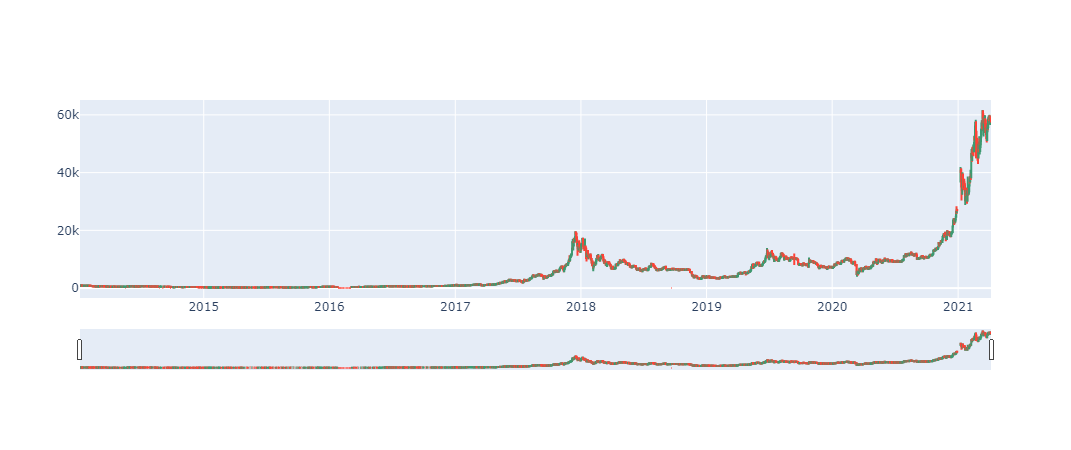

In [8]:
fig = go.Figure(data=[go.Candlestick(x=df_sample_quandl_kraken.index,
                open=df_sample_quandl_kraken['Open'],
                high=df_sample_quandl_kraken['High'],
                low=df_sample_quandl_kraken['Low'],
                close=df_sample_quandl_kraken['Close'])])
fig.show()

### Look at Coingecko market & exchange data

In [9]:
coins_list = cg.get_coins_list()
coin_names = []
for item in coins_list:
    coin_names.append(item['name'])

In [10]:
# jprint(coins_list)

In [11]:
markets_list = cg.get_coins_markets(vs_currency='usd')
market_names = []
for item in markets_list:
    market_names.append(item['name'])
len(market_names)

100

In [12]:
# jprint(markets_list)

In [13]:
df_cg_markets = pd.DataFrame.from_dict(markets_list)
df_cg_markets.head()

id symbol          name  \
0      bitcoin    btc       Bitcoin   
1     ethereum    eth      Ethereum   
2  binancecoin    bnb  Binance Coin   
3       ripple    xrp           XRP   
4       tether   usdt        Tether   

                                               image  current_price  \
0  https://assets.coingecko.com/coins/images/1/la...       58062.00   
1  https://assets.coingecko.com/coins/images/279/...        2115.06   
2  https://assets.coingecko.com/coins/images/825/...         404.46   
3  https://assets.coingecko.com/coins/images/44/l...           1.10   
4  https://assets.coingecko.com/coins/images/325/...           1.00   

      market_cap  market_cap_rank  fully_diluted_valuation  total_volume  \
0  1084341670321                1             1.219306e+12   61497704158   
1   244306254505                2                      NaN   33391498273   
2    62712349429                3             6.920542e+10    6375820135   
3    50389991767                4                      NaN   29325146993   
4    43181183731                5                      NaN  144419699226   

   high_24h  ...  total_supply   max_supply       ath  ath_change_percentage  \
0  59735.00  ...  2.100000e+07   21000000.0  61712.00               -5.91409   
1   2153.08  ...           NaN          NaN   2153.08               -1.56438   
2    410.46  ...  1.705337e+08  170533651.9    410.46               -0.58337   
3      1.08  ...  1.000000e+11          NaN      3.40              -67.70193   
4      1.01  ...  4.316810e+10          NaN      1.32              -24.39675   

                   ath_date        atl  atl_change_percentage  \
0  2021-03-13T20:49:26.606Z  67.810000           8.552607e+04   
1  2021-04-06T01:14:31.985Z   0.432979           4.893935e+05   
2  2021-04-06T22:44:06.207Z   0.039818           1.024744e+06   
3  2018-01-07T00:00:00.000Z   0.002686           4.076185e+04   
4  2018-07-24T00:00:00.000Z   0.572521           7.471902e+01   

                   atl_date  \
0  2013-07-06T00:00:00.000Z   
1  2015-10-20T00:00:00.000Z   
2  2017-10-19T00:00:00.000Z   
3  2014-05-22T00:00:00.000Z   
4  2015-03-02T00:00:00.000Z   

                                                 roi              last_updated  
0                                               None  2021-04-06T23:59:17.928Z  
1  {'times': 47.70563336934246, 'currency': 'btc'...  2021-04-06T23:59:58.520Z  
2                                               None  2021-04-06T23:59:49.021Z  
3                                               None  2021-04-06T23:59:02.065Z  
4                                               None  2021-04-06T23:07:04.923Z  

[5 rows x 26 columns]

In [14]:
exchanges_list = cg.get_exchanges_list()
exchange_names = []
for item in exchanges_list:
    exchange_names.append(item['name'])
len(exchange_names)

100

In [15]:
# jprint(exchanges_list)

In [16]:
df_cg_exchanges = pd.DataFrame.from_dict(exchanges_list)
df_cg_exchanges.head()

id          name  year_established                 country  \
0   binance       Binance            2017.0          Cayman Islands   
1      gdax  Coinbase Pro            2012.0           United States   
2    kraken        Kraken            2011.0           United States   
3  bitfinex      Bitfinex            2014.0  British Virgin Islands   
4      gate       Gate.io               NaN               Hong Kong   

  description                         url  \
0                https://www.binance.com/   
1                https://www.coinbase.com   
2              https://r.kraken.com/Q1m9x   
3                https://www.bitfinex.com   
4                        https://gate.io/   

                                               image has_trading_incentive  \
0  https://assets.coingecko.com/markets/images/52...                 False   
1  https://assets.coingecko.com/markets/images/23...                 False   
2  https://assets.coingecko.com/markets/images/29...                 False   
3  https://assets.coingecko.com/markets/images/4/...                 False   
4  https://assets.coingecko.com/markets/images/60...                 False   

   trust_score  trust_score_rank  trade_volume_24h_btc  \
0           10                 1         744359.715995   
1           10                 2          54481.279906   
2           10                 3          32684.486136   
3           10                 4          24867.660256   
4           10                 5          19250.917817   

   trade_volume_24h_btc_normalized  
0                    744359.715995  
1                     54481.279906  
2                     32684.486136  
3                     24867.660256  
4                     19250.917817

### Lokk at Coingecko BTC data

In [17]:
start_date = datetime.strptime("2014-01-07", "%Y-%m-%d")
end_date = datetime.strptime("2021-04-01", "%Y-%m-%d")
timestamp_start = datetime.timestamp(start_date)
timestamp_end = datetime.timestamp(end_date)

In [18]:
btc_charts_data = cg.get_coin_market_chart_range_by_id("bitcoin", "usd", timestamp_start, timestamp_end)

In [19]:
# jprint(btc_charts_data)

In [20]:
for key, value in enumerate(btc_charts_data):
    elements = []
    for element in btc_charts_data[value]:
        elements.append(element)
    print(f"{value}: # {len(elements)}")

prices: # 2640
market_caps: # 2639
total_volumes: # 2640


In [21]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)

dates = []
for stamp in df_btc_charts_data_mc['timestamp']:
    dates.append(datetime.fromtimestamp(stamp /1e3).strftime('%Y-%m-%d'))

df_btc_charts_data_mc['date'] = np.array(dates)
df_btc_charts_data_mc.set_index('date', inplace=True)
df_btc_charts_data_mc.drop('timestamp', axis=1, inplace=True)
df_btc_charts_data_mc.head()


market_cap
date                    
2014-01-07  1.010768e+10
2014-01-08  1.025634e+10
2014-01-09  1.044391e+10
2014-01-10  1.057044e+10
2014-01-11  1.109459e+10

In [22]:
df_btc_charts_data_pc = pd.DataFrame.from_dict(btc_charts_data['prices'])
df_btc_charts_data_pc.rename(columns={0:'timestamp', 1:'price'}, inplace=True)

dates = []
for stamp in df_btc_charts_data_pc['timestamp']:
    dates.append(datetime.fromtimestamp(stamp /1e3).strftime('%Y-%m-%d'))

df_btc_charts_data_pc['date'] = np.array(dates)
df_btc_charts_data_pc.set_index('date', inplace=True)
df_btc_charts_data_pc.drop('timestamp', axis=1, inplace=True)
df_btc_charts_data_pc.head()


price
date              
2014-01-07  826.50
2014-01-08  838.32
2014-01-09  853.29
2014-01-10  863.30
2014-01-11  905.72

In [23]:
df_btc_charts_data_vol = pd.DataFrame.from_dict(btc_charts_data['total_volumes'])
df_btc_charts_data_vol.rename(columns={0:'timestamp', 1:'tot_vol'}, inplace=True)

dates = []
for stamp in df_btc_charts_data_vol['timestamp']:
    dates.append(datetime.fromtimestamp(stamp /1e3).strftime('%Y-%m-%d'))

df_btc_charts_data_vol['date'] = np.array(dates)
df_btc_charts_data_vol.set_index('date', inplace=True)
df_btc_charts_data_vol.drop('timestamp', axis=1, inplace=True)
df_btc_charts_data_vol.head()


tot_vol
date                  
2014-01-07  80268100.0
2014-01-08  78060300.0
2014-01-09  58813600.0
2014-01-10  29763600.0
2014-01-11  48299500.0

In [24]:
df_merged = df_btc_charts_data_mc.merge(df_btc_charts_data_pc, how='right', left_index=True, right_index=True)

In [25]:
df_cg_btc_chart_data = df_merged.merge(df_btc_charts_data_vol, how='inner', left_index=True, right_index=True)

In [26]:
df_cg_btc_chart_data.shape

(2652, 3)

In [27]:
df_cg_btc_chart_data.head()

market_cap   price     tot_vol
date                                        
2014-01-07  1.010768e+10  826.50  80268100.0
2014-01-08  1.025634e+10  838.32  78060300.0
2014-01-09  1.044391e+10  853.29  58813600.0
2014-01-10  1.057044e+10  863.30  29763600.0
2014-01-11  1.109459e+10  905.72  48299500.0

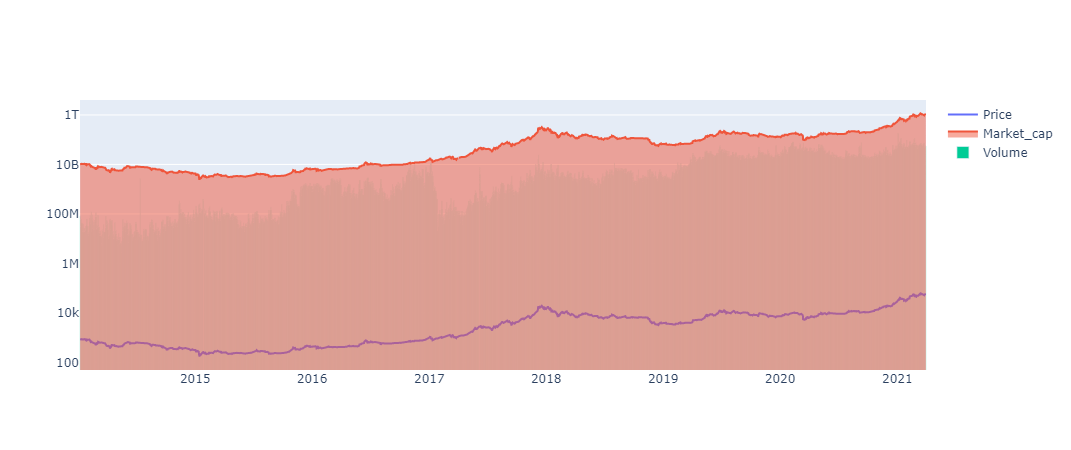

In [28]:
fig = go.Figure()

date = df_cg_btc_chart_data.index
price = df_cg_btc_chart_data['price']
market_cap = df_cg_btc_chart_data['market_cap']
volume = df_cg_btc_chart_data['tot_vol']

fig.add_trace(go.Scatter(x=date, y=price,
                    mode='lines',
                    name='Price'))

fig.add_trace(go.Scatter(x=date, y=market_cap,
                    fill='tozeroy', name='Market_cap'))

fig.add_trace(go.Bar(x=date, y=volume,
                    name='Volume'))

fig.update_yaxes(type="log")

fig.show()

### Look at Yahoo Finance BTC data

In [29]:
df_BTC_yahoo = get_datareader_data('BTC-USD', "yahoo")
df_BTC_yahoo.head()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC-USD.json from cache


High         Low        Open       Close    Volume  \
2016-04-07  425.360992  419.635010  422.907013  420.348999  63454700   
2016-04-08  420.890991  416.515015  420.811005  419.411011  49792700   
2016-04-09  422.434998  419.256989  419.592010  421.563995  73478600   
2016-04-10  422.739014  420.532990  421.872009  422.483002  50747500   
2016-04-11  427.277008  422.842987  422.842987  425.190002  70728800   

             Adj Close  
2016-04-07  420.348999  
2016-04-08  419.411011  
2016-04-09  421.563995  
2016-04-10  422.483002  
2016-04-11  425.190002

### Comparison Chart BTC Closing Price

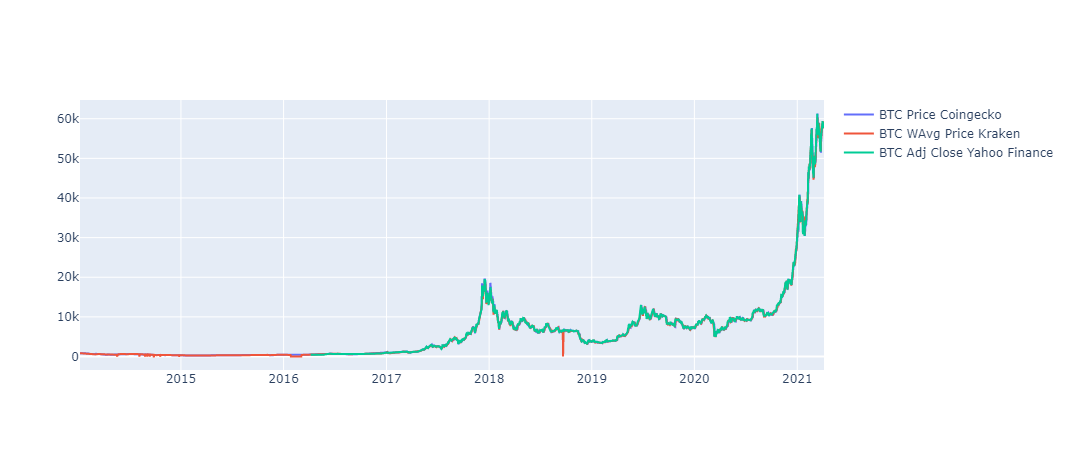

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_cg_btc_chart_data.index, 
                        y=df_cg_btc_chart_data['price'],
                        mode='lines',
                        name='BTC Price Coingecko'))

fig.add_trace(go.Scatter(x=df_sample_quandl_kraken.index,
                        y=df_sample_quandl_kraken['Weighted Price'],
                        mode='lines',
                        name='BTC WAvg Price Kraken'))

fig.add_trace(go.Scatter(x=df_BTC_yahoo.index,
                        y=df_BTC_yahoo['Adj Close'],
                        mode='lines',
                        name='BTC Adj Close Yahoo Finance'))

fig.show()

### Check for zeros an Null's in the Initial BTC Data (Quandl, Coingecko, Yahoo Finance)

In [31]:
df_sample_quandl_kraken[df_sample_quandl_kraken['Weighted Price']==0].count()

Open                 49
High                 49
Low                  49
Close                49
Volume (BTC)         49
Volume (Currency)    49
Weighted Price       49
dtype: int64

In [32]:
df_sample_quandl_kraken.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume (BTC)         0
Volume (Currency)    0
Weighted Price       0
dtype: int64

In [33]:
df_cg_btc_chart_data[df_cg_btc_chart_data['price']==0].count()

market_cap    0
price         0
tot_vol       0
dtype: int64

In [34]:
df_cg_btc_chart_data.isna().sum()

market_cap    1
price         0
tot_vol       0
dtype: int64

In [35]:
df_BTC_yahoo[df_BTC_yahoo['Adj Close']==0].count()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [36]:
df_BTC_yahoo.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

### Look for relevance in  Markets and Exchanges 

In [37]:
df_cg_exchanges_sliced = df_cg_exchanges[['id', 'name', 'trust_score_rank', 'trade_volume_24h_btc']]
df_cg_exchanges_top10 = df_cg_exchanges_sliced.nsmallest(11, 'trust_score_rank').sort_values(by='trade_volume_24h_btc', 
                                                  ascending=False)
df_cg_exchanges_top10 = df_cg_exchanges_top10[df_cg_exchanges_top10.id != 'kraken'] 
df_cg_exchanges_top10

id          name  trust_score_rank  trade_volume_24h_btc
0      binance       Binance                 1         744359.715995
8        huobi  Huobi Global                 9         232255.108225
9         okex          OKEx                10         169602.884394
1         gdax  Coinbase Pro                 2          54481.279906
10      kucoin        KuCoin                11          26832.272163
3     bitfinex      Bitfinex                 4          24867.660256
4         gate       Gate.io                 5          19250.917817
5   binance_us    Binance US                 6          11769.680269
6   crypto_com    Crypto.com                 7           6331.986868
7       gemini        Gemini                 8           3355.797581

In [38]:
df_cg_markets_sliced = df_cg_markets[['id', 'symbol', 'name', 'market_cap', 'market_cap_rank', 'total_volume', 'total_supply', 
                               'current_price']]
df_cg_markets_top10 = df_cg_markets_sliced.nsmallest(12, 'market_cap_rank').sort_values(by='total_volume', ascending=False)
df_cg_markets_top10.drop(df_cg_markets_top10[(df_cg_markets_top10['id']=='tether') | (df_cg_markets_top10['id']=='bitcoin')].index, 
                     inplace=True)
df_cg_markets_top10

id symbol          name    market_cap  market_cap_rank  \
1       ethereum    eth      Ethereum  244306254505                2   
3         ripple    xrp           XRP   50389991767                4   
8       litecoin    ltc      Litecoin   15857642401                9   
10  bitcoin-cash    bch  Bitcoin Cash   12401540441               11   
2    binancecoin    bnb  Binance Coin   62712349429                3   
6        cardano    ada       Cardano   40174301242                7   
11       stellar    xlm       Stellar   12243445763               12   
9      chainlink   link     Chainlink   14516869513               10   
5       polkadot    dot      Polkadot   42688387270                6   
7        uniswap    uni       Uniswap   16309533175                8   

    total_volume  total_supply  current_price  
1    33391498273           NaN    2115.060000  
3    29325146993  1.000000e+11       1.100000  
8    11548226719  8.400000e+07     237.560000  
10    7237138909  2.100000e+07     663.630000  
2     6375820135  1.705337e+08     404.460000  
6     5716309192  4.500000e+10       1.260000  
11    3755374948  5.000000e+10       0.537331  
9     2679304051  1.000000e+09      34.770000  
5     2250595125  1.062291e+09      43.420000  
7     1030841238  1.000000e+09      31.350000

In [39]:
exchanges_sel = list(df_cg_exchanges_top10['id'].str.upper())
manual_add = ['BITSTAMP', 'ITBIT', 'COINBASE']
for exchange in manual_add:
    exchanges_sel.append(exchange)
exchanges_sel

['BINANCE',
 'HUOBI',
 'OKEX',
 'GDAX',
 'KUCOIN',
 'BITFINEX',
 'GATE',
 'BINANCE_US',
 'CRYPTO_COM',
 'GEMINI',
 'BITSTAMP',
 'ITBIT',
 'COINBASE']

In [40]:
markets_sel = df_cg_markets_top10['symbol'].str.upper()
markets_sel

1      ETH
3      XRP
8      LTC
10     BCH
2      BNB
6      ADA
11     XLM
9     LINK
5      DOT
7      UNI
Name: symbol, dtype: object

### Pull Top10 more exchange data for BTC from Quandl

<p> We had several days with 0 Price on Kraken so we make the BTC Price more robust by pulling data from some more exchanges (we selected the ones with the top10 trust score and added some manually) /<p>

In [41]:
from quandl.errors.quandl_error import NotFoundError

exchanges = exchanges_sel

df_run = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run.append(df)
        
    except NotFoundError as e:
        continue


Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-COINBASEUSD.json from cache


In [43]:
btc_exchange_df = df_sample_quandl_kraken
btc_exchange_df['Exchange'] = 'KRAKEN'

df_new = pd.concat(df_run)
btc_exchange_df = btc_exchange_df.append(df_new)

In [44]:
btc_exchange_df.head()

Open       High        Low      Close  Volume (BTC)  \
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price Exchange  
2014-01-07       13151.472844      841.835522   KRAKEN  
2014-01-08       16097.329584      839.156269   KRAKEN  
2014-01-09        6784.249982      831.572913   KRAKEN  
2014-01-10        6780.220188      844.938794   KRAKEN  
2014-01-11       16698.566929      890.671709   KRAKEN

In [45]:
btc_exchange_df.shape

(10682, 8)

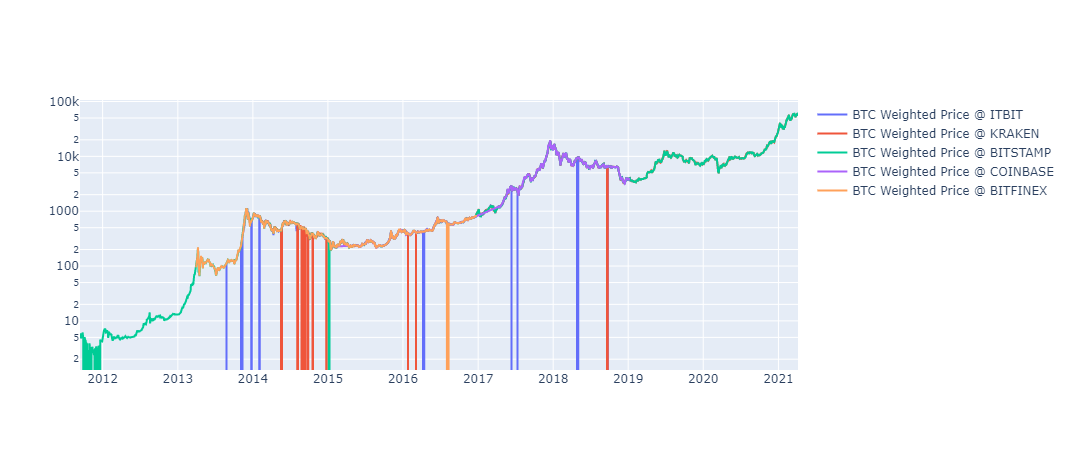

In [46]:
fig = go.Figure()

exchanges_lab = set(btc_exchange_df['Exchange'])

for id, exchange in enumerate(exchanges_lab):
    fig.add_trace(go.Scatter(x=btc_exchange_df[btc_exchange_df['Exchange']==exchange].index, 
                             y=btc_exchange_df[btc_exchange_df['Exchange']==exchange]['Weighted Price'],
                             mode='lines',
                             name=f"BTC Weighted Price @ {exchange}"))

fig.update_yaxes(type="log")
    
fig.show()

In [47]:
btc_exchange_df.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume (BTC)         0
Volume (Currency)    0
Weighted Price       0
Exchange             0
dtype: int64

In [48]:
btc_exchange_df[btc_exchange_df['Weighted Price']==0].count()

Open                 193
High                 193
Low                  193
Close                193
Volume (BTC)         193
Volume (Currency)    193
Weighted Price       193
Exchange             193
dtype: int64

In [49]:
btc_exchange_df[btc_exchange_df['Close']==0].count()

Open                 193
High                 193
Low                  193
Close                193
Volume (BTC)         193
Volume (Currency)    193
Weighted Price       193
Exchange             193
dtype: int64

In [50]:
btc_exchange_df[btc_exchange_df['Volume (Currency)']==0].count()

Open                 193
High                 193
Low                  193
Close                193
Volume (BTC)         193
Volume (Currency)    193
Weighted Price       193
Exchange             193
dtype: int64

In [51]:
btc_exchange_df.replace(0, np.nan, inplace=True)

In [52]:
btc_exchange_df.isnull().values.any()

True

In [53]:
btc_exchange_df.isnull().sum().sum()

1351

In [54]:
btc_exchange_df.isna().sum()

Open                 193
High                 193
Low                  193
Close                193
Volume (BTC)         193
Volume (Currency)    193
Weighted Price       193
Exchange               0
dtype: int64

In [55]:
btc_exchange_df[btc_exchange_df.isna().any(axis=1)]

Open  High  Low  Close  Volume (BTC)  Volume (Currency)  \
2014-05-19   NaN   NaN  NaN    NaN           NaN                NaN   
2014-08-06   NaN   NaN  NaN    NaN           NaN                NaN   
2014-08-26   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-03   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-05   NaN   NaN  NaN    NaN           NaN                NaN   
...          ...   ...  ...    ...           ...                ...   
2018-04-29   NaN   NaN  NaN    NaN           NaN                NaN   
2018-04-30   NaN   NaN  NaN    NaN           NaN                NaN   
2018-05-01   NaN   NaN  NaN    NaN           NaN                NaN   
2018-05-02   NaN   NaN  NaN    NaN           NaN                NaN   
2018-09-21   NaN   NaN  NaN    NaN           NaN                NaN   

            Weighted Price Exchange  
2014-05-19             NaN   KRAKEN  
2014-08-06             NaN   KRAKEN  
2014-08-26             NaN   KRAKEN  
2014-09-03             NaN   KRAKEN  
2014-09-05             NaN   KRAKEN  
...                    ...      ...  
2018-04-29             NaN    ITBIT  
2018-04-30             NaN    ITBIT  
2018-05-01             NaN    ITBIT  
2018-05-02             NaN    ITBIT  
2018-09-21             NaN    ITBIT  

[193 rows x 8 columns]

In [56]:
btc_exchange_df['adj Weighted Price'] = btc_exchange_df.groupby('Exchange')['Weighted Price'].transform(lambda x: x.fillna(x.mean()))

In [57]:
btc_df_filtered = btc_exchange_df[btc_exchange_df['Exchange']=="KRAKEN"]
btc_df_filtered[btc_df_filtered.isna().any(axis=1)]

Open  High  Low  Close  Volume (BTC)  Volume (Currency)  \
2014-05-19   NaN   NaN  NaN    NaN           NaN                NaN   
2014-08-06   NaN   NaN  NaN    NaN           NaN                NaN   
2014-08-26   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-03   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-05   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-12   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-26   NaN   NaN  NaN    NaN           NaN                NaN   
2014-09-27   NaN   NaN  NaN    NaN           NaN                NaN   
2014-10-19   NaN   NaN  NaN    NaN           NaN                NaN   
2014-12-25   NaN   NaN  NaN    NaN           NaN                NaN   
2016-01-27   NaN   NaN  NaN    NaN           NaN                NaN   
2016-01-28   NaN   NaN  NaN    NaN           NaN                NaN   
2016-01-29   NaN   NaN  NaN    NaN           NaN                NaN   
2016-01-30   NaN   NaN  NaN    NaN           NaN                NaN   
2016-01-31   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-01   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-02   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-03   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-04   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-05   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-06   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-07   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-08   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-09   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-10   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-11   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-12   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-13   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-14   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-15   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-16   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-17   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-18   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-19   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-20   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-21   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-22   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-23   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-24   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-25   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-26   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-27   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-28   NaN   NaN  NaN    NaN           NaN                NaN   
2016-02-29   NaN   NaN  NaN    NaN           NaN                NaN   
2016-03-01   NaN   NaN  NaN    NaN           NaN                NaN   
2016-03-02   NaN   NaN  NaN    NaN           NaN                NaN   
2016-03-03   NaN   NaN  NaN    NaN           NaN                NaN   
2016-03-04   NaN   NaN  NaN    NaN           NaN                NaN   
2018-09-21   NaN   NaN  NaN    NaN           NaN                NaN   

            Weighted Price Exchange  adj Weighted Price  
2014-05-19             NaN   KRAKEN         5988.107632  
2014-08-06             NaN   KRAKEN         5988.107632  
2014-08-26             NaN   KRAKEN         5988.107632  
2014-09-03             NaN   KRAKEN         5988.107632  
2014-09-05             NaN   KRAKEN         5988.107632  
2014-09-12             NaN   KRAKEN         5988.107632  
2014-09-26             NaN   KRAKEN         5988.107632

In [58]:
btc_df_filtered = btc_exchange_df[btc_exchange_df['Exchange']=="BITSTAMP"]
btc_df_filtered[btc_df_filtered.isna().any(axis=1)]

Open  High  Low  Close  Volume (BTC)  Volume (Currency)  \
2011-09-30   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-01   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-02   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-15   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-16   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-18   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-19   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-22   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-23   NaN   NaN  NaN    NaN           NaN                NaN   
2011-10-27   NaN   NaN  NaN    NaN           NaN                NaN   
2011-11-02   NaN   NaN  NaN    NaN           NaN                NaN   
2011-11-03   NaN   NaN  NaN    NaN           NaN                NaN   
2011-11-07   NaN   NaN  NaN    NaN           NaN                NaN   
2011-11-23   NaN   NaN  NaN    NaN           NaN                NaN   
2011-11-27   NaN   NaN  NaN    NaN           NaN                NaN   
2011-12-04   NaN   NaN  NaN    NaN           NaN                NaN   
2011-12-09   NaN   NaN  NaN    NaN           NaN                NaN   
2011-12-17   NaN   NaN  NaN    NaN           NaN                NaN   
2015-01-06   NaN   NaN  NaN    NaN           NaN                NaN   
2015-01-07   NaN   NaN  NaN    NaN           NaN                NaN   
2015-01-08   NaN   NaN  NaN    NaN           NaN                NaN   

            Weighted Price  Exchange  adj Weighted Price  
2011-09-30             NaN  BITSTAMP         4503.154276  
2011-10-01             NaN  BITSTAMP         4503.154276  
2011-10-02             NaN  BITSTAMP         4503.154276  
2011-10-15             NaN  BITSTAMP         4503.154276  
2011-10-16             NaN  BITSTAMP         4503.154276  
2011-10-18             NaN  BITSTAMP         4503.154276  
2011-10-19             NaN  BITSTAMP         4503.154276  
2011-10-22             NaN  BITSTAMP         4503.154276  
2011-10-23             NaN  BITSTAMP         4503.154276  
2011-10-27             NaN  BITSTAMP         4503.154276  
2011-11-02             NaN  BITSTAMP         4503.154276  
2011-11-03             NaN  BITSTAMP         4503.154276  
2011-11-07             NaN  BITSTAMP         4503.154276  
2011-11-23             NaN  BITSTAMP         4503.154276  
2011-11-27             NaN  BITSTAMP         4503.154276  
2011-12-04             NaN  BITSTAMP         4503.154276  
2011-12-09             NaN  BITSTAMP         4503.154276  
2011-12-17             NaN  BITSTAMP         4503.154276  
2015-01-06             NaN  BITSTAMP         4503.154276  
2015-01-07             NaN  BITSTAMP         4503.154276  
2015-01-08             NaN  BITSTAMP         4503.154276

In [59]:
btc_df_filtered = btc_exchange_df[btc_exchange_df['Exchange']=="ITBIT"]
btc_df_filtered[btc_df_filtered.isna().any(axis=1)]

Open  High  Low  Close  Volume (BTC)  Volume (Currency)  \
2013-08-27   NaN   NaN  NaN    NaN           NaN                NaN   
2013-08-28   NaN   NaN  NaN    NaN           NaN                NaN   
2013-08-29   NaN   NaN  NaN    NaN           NaN                NaN   
2013-08-30   NaN   NaN  NaN    NaN           NaN                NaN   
2013-08-31   NaN   NaN  NaN    NaN           NaN                NaN   
...          ...   ...  ...    ...           ...                ...   
2018-04-29   NaN   NaN  NaN    NaN           NaN                NaN   
2018-04-30   NaN   NaN  NaN    NaN           NaN                NaN   
2018-05-01   NaN   NaN  NaN    NaN           NaN                NaN   
2018-05-02   NaN   NaN  NaN    NaN           NaN                NaN   
2018-09-21   NaN   NaN  NaN    NaN           NaN                NaN   

            Weighted Price Exchange  adj Weighted Price  
2013-08-27             NaN    ITBIT          2514.09444  
2013-08-28             NaN    ITBIT          2514.09444  
2013-08-29             NaN    ITBIT          2514.09444  
2013-08-30             NaN    ITBIT          2514.09444  
2013-08-31             NaN    ITBIT          2514.09444  
...                    ...      ...                 ...  
2018-04-29             NaN    ITBIT          2514.09444  
2018-04-30             NaN    ITBIT          2514.09444  
2018-05-01             NaN    ITBIT          2514.09444  
2018-05-02             NaN    ITBIT          2514.09444  
2018-09-21             NaN    ITBIT          2514.09444  

[116 rows x 9 columns]

In [60]:
btc_exchange_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10682 entries, 2014-01-07 to 2019-01-07
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                10489 non-null  float64
 1   High                10489 non-null  float64
 2   Low                 10489 non-null  float64
 3   Close               10489 non-null  float64
 4   Volume (BTC)        10489 non-null  float64
 5   Volume (Currency)   10489 non-null  float64
 6   Weighted Price      10489 non-null  float64
 7   Exchange            10682 non-null  object 
 8   adj Weighted Price  10682 non-null  float64
dtypes: float64(8), object(1)
memory usage: 834.5+ KB


In [61]:
btc_exchange_df.describe()

Open          High           Low         Close   Volume (BTC)  \
count  10489.000000  10489.000000  10489.000000  10489.000000   10489.000000   
mean    3884.658854   4008.040939   3746.936272   3893.874318    8475.240312   
std     7110.918511   7359.363455   6833.344411   7139.723994   12295.201697   
min        2.220000      2.270000      0.010000      2.240000       0.000038   
25%      350.000010    359.300000    340.000000    350.040000    2187.488785   
50%      655.300000    668.800000    638.790000    655.720000    5162.802800   
75%     6401.010000   6521.100000   6292.690000   6400.000000   10158.088742   
max    61177.030000  61781.830000  59001.000000  61174.900000  274465.728234   

       Volume (Currency)  Weighted Price  adj Weighted Price  
count       1.048900e+04    10489.000000        10682.000000  
mean        3.220978e+07     3881.371227         3875.132934  
std         7.471645e+07     7111.162982         7050.119659  
min         1.999896e-02        2.240360            2.240360  
25%         1.042214e+06      349.805177          355.738667  
50%         4.984849e+06      653.472898          662.707394  
75%         3.194743e+07     6402.941592         6373.846469  
max         1.391748e+09    60429.059780        60429.059780

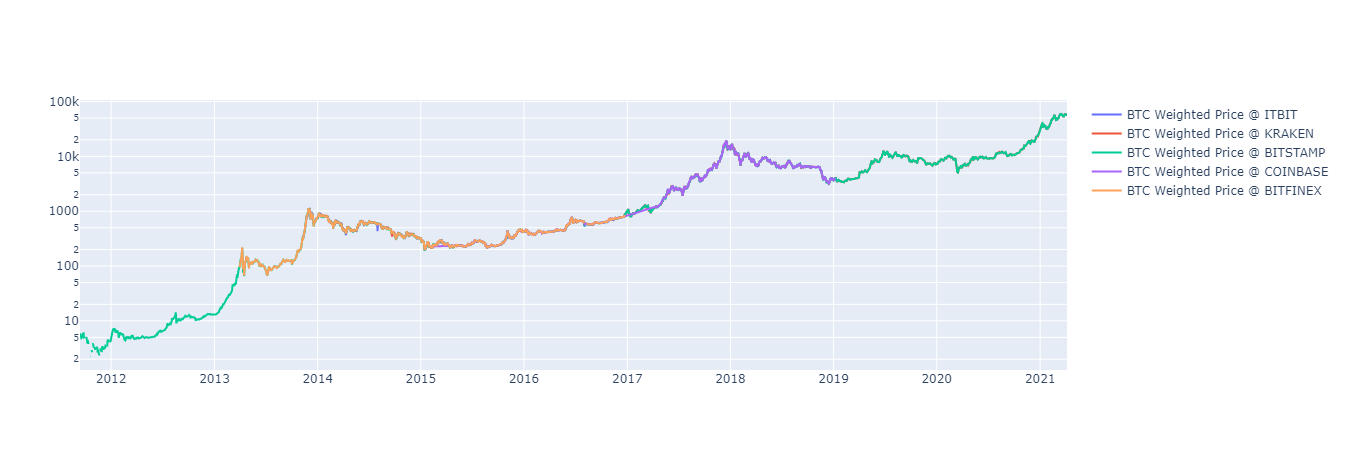

In [62]:
fig = go.Figure()

exchanges_lab = set(btc_exchange_df['Exchange'])

for id, exchange in enumerate(exchanges_lab):
    fig.add_trace(go.Scatter(x=btc_exchange_df[btc_exchange_df['Exchange']==exchange].index, 
                             y=btc_exchange_df[btc_exchange_df['Exchange']==exchange]['Weighted Price'],
                             mode='lines',
                             name=f"BTC Weighted Price @ {exchange}"))

fig.update_yaxes(type="log")
    
fig.show()

### Pull Altcoin Data

In [63]:
from quandl.errors.quandl_error import NotFoundError

markets = markets_sel

df_run_mkt = []
    
for market in markets:
    market_code = f"BITFINEX/{market}BTC"
   
    try:
        df = get_quandl_data(market_code)
        df['Market'] = market
        df_run_mkt.append(df)
        
    except NotFoundError as e:
        continue

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ETHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XRPBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-LTCBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BCHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ADABTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XLMBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-DOTBTC.json from cache


In [64]:
df_run_mkt

[                High       Low       Mid      Last       Bid       Ask  \
 2016-03-14  0.050580  0.028241  0.031181  0.031103  0.031102  0.031260   
 2016-03-15  0.032004  0.027950  0.031298  0.031399  0.031207  0.031390   
 2016-03-16  0.033500  0.030465  0.030699  0.030690  0.030690  0.030709   
 2016-03-17  0.030989  0.024759  0.026878  0.026816  0.026821  0.026935   
 2016-03-18  0.026960  0.020150  0.026555  0.026509  0.026506  0.026605   
 ...              ...       ...       ...       ...       ...       ...   
 2021-04-02  0.035837  0.033157  0.035680  0.035660  0.035677  0.035684   
 2021-04-03  0.036256  0.034593  0.035379  0.035342  0.035369  0.035389   
 2021-04-04  0.035938  0.034946  0.035586  0.035565  0.035580  0.035592   
 2021-04-05  0.036129  0.035223  0.036021  0.036056  0.036014  0.036029   
 2021-04-06  0.036560  0.035588  0.036533  0.036533  0.036532  0.036534   
 
                    Volume Market  
 2016-03-14  111142.045174    ETH  
 2016-03-15   62965.262239

In [65]:
df_altcoin = pd.concat(df_run_mkt)

In [66]:
df_altcoin.head()

High       Low       Mid      Last       Bid       Ask  \
2016-03-14  0.050580  0.028241  0.031181  0.031103  0.031102  0.031260   
2016-03-15  0.032004  0.027950  0.031298  0.031399  0.031207  0.031390   
2016-03-16  0.033500  0.030465  0.030699  0.030690  0.030690  0.030709   
2016-03-17  0.030989  0.024759  0.026878  0.026816  0.026821  0.026935   
2016-03-18  0.026960  0.020150  0.026555  0.026509  0.026506  0.026605   

                   Volume Market  
2016-03-14  111142.045174    ETH  
2016-03-15   62965.262239    ETH  
2016-03-16   55947.825399    ETH  
2016-03-17   94445.983815    ETH  
2016-03-18  141106.891752    ETH

In [67]:
df_altcoin['Exchange'] = 'BITFINEX'
df_altcoin.rename(columns={'Bid':'Open', 'Last':'Close'}, inplace=True)
df_altcoin.drop(columns=['Mid', 'Ask'])

High       Low     Close      Open         Volume Market  \
2016-03-14  0.050580  0.028241  0.031103  0.031102  111142.045174    ETH   
2016-03-15  0.032004  0.027950  0.031399  0.031207   62965.262239    ETH   
2016-03-16  0.033500  0.030465  0.030690  0.030690   55947.825399    ETH   
2016-03-17  0.030989  0.024759  0.026816  0.026821   94445.983815    ETH   
2016-03-18  0.026960  0.020150  0.026509  0.026506  141106.891752    ETH   
...              ...       ...       ...       ...            ...    ...   
2021-04-02  0.000677  0.000627  0.000671  0.000670   11491.802162    DOT   
2021-04-03  0.000787  0.000675  0.000735  0.000733   34211.602176    DOT   
2021-04-04  0.000788  0.000718  0.000749  0.000748    8792.247871    DOT   
2021-04-05  0.000768  0.000736  0.000751  0.000748    5870.475782    DOT   
2021-04-06  0.000780  0.000726  0.000742  0.000742   12205.379353    DOT   

            Exchange  
2016-03-14  BITFINEX  
2016-03-15  BITFINEX  
2016-03-16  BITFINEX  
2016-03-17  BITFINEX  
2016-03-18  BITFINEX  
...              ...  
2021-04-02  BITFINEX  
2021-04-03  BITFINEX  
2021-04-04  BITFINEX  
2021-04-05  BITFINEX  
2021-04-06  BITFINEX  

[7232 rows x 7 columns]

In [68]:
column_names=['Open', 'High', 'Low', 'Close', 'Volume', 'Exchange', 'Market']
df_altcoin = df_altcoin.reindex(columns=column_names)
df_altcoin.head()

Open      High       Low     Close         Volume  Exchange  \
2016-03-14  0.031102  0.050580  0.028241  0.031103  111142.045174  BITFINEX   
2016-03-15  0.031207  0.032004  0.027950  0.031399   62965.262239  BITFINEX   
2016-03-16  0.030690  0.033500  0.030465  0.030690   55947.825399  BITFINEX   
2016-03-17  0.026821  0.030989  0.024759  0.026816   94445.983815  BITFINEX   
2016-03-18  0.026506  0.026960  0.020150  0.026509  141106.891752  BITFINEX   

           Market  
2016-03-14    ETH  
2016-03-15    ETH  
2016-03-16    ETH  
2016-03-17    ETH  
2016-03-18    ETH

In [69]:
mask = df_cg_exchanges['id'].str.contains("coin", regex=False)
df_cg_exchanges[mask]['id']

10             kucoin
20        bitcoin_com
23           coinbene
29           coinsbit
40        max_maicoin
47          cointiger
48            coinone
63          coincheck
67             okcoin
70    mercado_bitcoin
78           coindeal
87            coineal
98         coinmargin
Name: id, dtype: object

In [70]:
df_mining = get_quandl_data('BITCOINWATCH/MINING')

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITCOINWATCH-MINING.json from cache


In [71]:
df_mining.head()

Total BTC  Market Cap  Transactions last 24h  \
2013-08-26   11608775  1406983298                53292.0   
2013-08-27   11612775  1504095211                57316.0   
2013-08-28   11617025  1342254303                66380.0   
2013-08-29   11621875  1381724719                61617.0   
2013-08-30   11626775  1391724968                60440.0   

            Transactions avg. per hour  Bitcoins sent last 24h  \
2013-08-26                     2220.50               641072.88   
2013-08-27                     2388.17               882731.69   
2013-08-28                     2765.83               831597.17   
2013-08-29                     2567.38              2694076.29   
2013-08-30                     2518.33               684111.74   

            Bitcoins sent avg. per hour   Count  Blocks last 24h  \
2013-08-26                     26711.37  254350              165   
2013-08-27                     36780.49  254510              171   
2013-08-28                     34649.88  254680              170   
2013-08-29                    112253.18  254874              194   
2013-08-30                     28504.66  255070              196   

            Blocks avg. per hour  Difficulty  Next Difficulty  \
2013-08-26                  6.88    65750060         68498336   
2013-08-27                  7.13    65750060         70053502   
2013-08-28                  7.08    65750060         70879556   
2013-08-29                  8.08    65750060         72700400   
2013-08-30                  8.17    65750060         75286537   

            Network Hashrate Terahashs  Network Hashrate PetaFLOPS  
2013-08-26                      490.33                     6227.19  
2013-08-27                      501.46                     6368.57  
2013-08-28                      507.38                     6443.67  
2013-08-29                      520.41                     6609.20  
2013-08-30                      538.92                     6844.31

In [72]:
altcoins = markets_sel
df_run_altcoin = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin.append(df)
                
    except ValueError as e:
        continue

df_poloniex_altcoin = pd.concat(df_run_altcoin)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache


In [73]:
df_poloniex_altcoin

high       low       open     close       volume  \
date                                                                
2015-08-08  50.000000  0.002620  50.000000  0.003125  1205.803321   
2015-08-09   0.004100  0.002400   0.003000  0.002581   898.123434   
2015-08-10   0.002902  0.002200   0.002650  0.002645   718.365266   
2015-08-11   0.004400  0.002414   0.002650  0.003950  3007.274111   
2015-08-12   0.004882  0.002910   0.003955  0.004500  4690.075032   
...               ...       ...        ...       ...          ...   
2021-03-27   0.000640  0.000576   0.000602  0.000587    13.385638   
2021-03-28   0.000588  0.000571   0.000582  0.000576     1.097758   
2021-03-29   0.000601  0.000577   0.000578  0.000594     2.933152   
2021-03-30   0.000596  0.000574   0.000596  0.000579     1.484420   
2021-03-31   0.000647  0.000573   0.000581  0.000630     8.819756   

             quoteVolume  weightedAverage Market  
date                                              
2015-08-08  2.662061e+05         0.004530    ETH  
2015-08-09  3.139879e+05         0.002860    ETH  
2015-08-10  2.845754e+05         0.002524    ETH  
2015-08-11  9.151385e+05         0.003286    ETH  
2015-08-12  1.117821e+06         0.004196    ETH  
...                  ...              ...    ...  
2021-03-27  2.241272e+04         0.000597    DOT  
2021-03-28  1.903069e+03         0.000577    DOT  
2021-03-29  4.948397e+03         0.000593    DOT  
2021-03-30  2.546847e+03         0.000583    DOT  
2021-03-31  1.442401e+04         0.000611    DOT  

[7743 rows x 8 columns]

In [74]:
df_poloniex_altcoin[df_poloniex_altcoin['Market']=="ETH"]

high       low       open     close       volume  \
date                                                                
2015-08-08  50.000000  0.002620  50.000000  0.003125  1205.803321   
2015-08-09   0.004100  0.002400   0.003000  0.002581   898.123434   
2015-08-10   0.002902  0.002200   0.002650  0.002645   718.365266   
2015-08-11   0.004400  0.002414   0.002650  0.003950  3007.274111   
2015-08-12   0.004882  0.002910   0.003955  0.004500  4690.075032   
...               ...       ...        ...       ...          ...   
2021-03-27   0.031058  0.030378   0.030873  0.030671   237.863055   
2021-03-28   0.030715  0.030198   0.030698  0.030237   218.832140   
2021-03-29   0.031698  0.030193   0.030225  0.031519   372.915209   
2021-03-30   0.031720  0.031033   0.031526  0.031356   409.977922   
2021-03-31   0.033033  0.030935   0.031349  0.032626   269.064868   

             quoteVolume  weightedAverage Market  
date                                              
2015-08-08  2.662061e+05         0.004530    ETH  
2015-08-09  3.139879e+05         0.002860    ETH  
2015-08-10  2.845754e+05         0.002524    ETH  
2015-08-11  9.151385e+05         0.003286    ETH  
2015-08-12  1.117821e+06         0.004196    ETH  
...                  ...              ...    ...  
2021-03-27  7.728591e+03         0.030777    ETH  
2021-03-28  7.176851e+03         0.030491    ETH  
2021-03-29  1.208612e+04         0.030855    ETH  
2021-03-30  1.308738e+04         0.031326    ETH  
2021-03-31  8.511722e+03         0.031611    ETH  

[2063 rows x 8 columns]

In [75]:
df_poloniex_btc = get_poloniex_data("USDT_BTC")

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\USDT_BTC.json from cache


In [76]:
df_poloniex_btc.head()

high     low        open   close      volume  quoteVolume  \
date                                                                       
2015-02-19  244.000  225.00  225.000000  244.00   46.276313     0.193117   
2015-02-20  245.000  240.25  240.250118  240.25   55.894897     0.230429   
2015-02-21  245.000  245.00  245.000000  245.00   14.722239     0.060091   
2015-02-22  249.000  235.00  245.000000  235.00  129.121248     0.539055   
2015-02-23  235.001  235.00  235.000002  235.00   96.567562     0.410926   

            weightedAverage  
date                         
2015-02-19       239.627778  
2015-02-20       242.568479  
2015-02-21       245.000000  
2015-02-22       239.532608  
2015-02-23       235.000062

In [77]:
df_btc_quandl = btc_exchange_df.sort_index()
df_btc_poloniex = df_poloniex_btc.sort_index()
df_btc_yahoo = df_BTC_yahoo.sort_index()
df_btc_cg = df_cg_btc_chart_data.sort_index()

print(df_btc_quandl.head(5))
print(df_btc_poloniex.head(5))
print(df_btc_yahoo.head(5))
print(df_btc_cg.head(5))


            Open  High   Low  Close  Volume (BTC)  Volume (Currency)  \
2011-09-13  5.80  6.00  5.65   5.97     58.371382         346.097389   
2011-09-14  5.58  5.72  5.52   5.53     61.145984         341.854813   
2011-09-15  5.12  5.24  5.00   5.13     80.140795         408.259002   
2011-09-16  4.82  4.87  4.80   4.85     39.914007         193.763147   
2011-09-17  4.87  4.87  4.87   4.87      0.300000           1.461000   

            Weighted Price  Exchange  adj Weighted Price  
2011-09-13        5.929231  BITSTAMP            5.929231  
2011-09-14        5.590798  BITSTAMP            5.590798  
2011-09-15        5.094272  BITSTAMP            5.094272  
2011-09-16        4.854515  BITSTAMP            4.854515  
2011-09-17        4.870000  BITSTAMP            4.870000  
               high     low        open   close      volume  quoteVolume  \
date                                                                       
2015-02-19  244.000  225.00  225.000000  244.00   46.276313  

In [78]:
df_btc_quandl.columns = df_btc_quandl.columns.str.title()
df_btc_poloniex.columns = df_btc_poloniex.columns.str.title()
df_btc_yahoo.columns = df_btc_yahoo.columns.str.title()
df_btc_cg.columns = df_btc_cg.columns.str.title()

print(df_btc_quandl.columns)
print(df_btc_poloniex.columns)
print(df_btc_yahoo.columns)
print(df_btc_cg.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume (Btc)', 'Volume (Currency)',
       'Weighted Price', 'Exchange', 'Adj Weighted Price'],
      dtype='object')
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Quotevolume',
       'Weightedaverage'],
      dtype='object')
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['Market_Cap', 'Price', 'Tot_Vol'], dtype='object')


In [79]:
df_btc_poloniex[df_btc_poloniex.index=='2021-04-02']

Empty DataFrame
Columns: [High, Low, Open, Close, Volume, Quotevolume, Weightedaverage]
Index: []

In [80]:
df_btc_quandl[df_btc_quandl.index=='2021-04-02']

Open      High      Low    Close  Volume (Btc)  \
2021-04-02  58744.0  60103.04  58450.0  59003.6   2564.600021   
2021-04-02  58732.9  60025.00  58500.0  59020.7   4199.507289   

            Volume (Currency)  Weighted Price  Exchange  Adj Weighted Price  
2021-04-02       1.522798e+08    59377.598448  BITSTAMP        59377.598448  
2021-04-02       2.492695e+08    59356.849782    KRAKEN        59356.849782

In [81]:
df_btc_yahoo.tail()

High           Low          Open         Close  \
2021-04-01  60267.187500  58869.281250  59098.878906  59384.312500   
2021-04-02  60110.269531  57603.890625  59397.410156  57603.890625   
2021-04-03  58913.746094  57168.675781  57604.839844  58758.554688   
2021-04-04  59891.296875  57694.824219  58760.875000  59057.878906   
2021-04-06  59475.406250  57683.464844  58562.832031  58266.964844   

                 Volume     Adj Close  
2021-04-01  58727860620  59384.312500  
2021-04-02  59641344484  57603.890625  
2021-04-03  50749662970  58758.554688  
2021-04-04  60706272115  59057.878906  
2021-04-06  66105147392  58266.964844

In [82]:
df_cg_exchanges['id']

0        binance
1           gdax
2         kraken
3       bitfinex
4           gate
         ...    
95     gmo_japan
96        bancor
97        btcbox
98    coinmargin
99       latoken
Name: id, Length: 100, dtype: object

## Data Ingestion: Populate BTC Data

In [83]:
from quandl.errors.quandl_error import NotFoundError

exchanges = list(df_cg_exchanges['id'].str.upper())

df_run_all = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run_all.append(df)
        
    except NotFoundError as e:
        continue

df_btc_quandl_new = pd.concat(df_run_all)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFLYERUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-P2PB2BUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-OKCOINUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-HITBTCUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-EXMOUSD.json from cache


In [84]:
df_btc_quandl_new = df_btc_quandl_new.sort_index()

In [85]:
df_btc_quandl_new.rename(columns={'Volume (BTC)': 'Volume_BTC', 'Volume (Currency)': 'Volume_USD'}, inplace=True)
df_btc_quandl_new

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2011-09-13      5.80      6.00      5.65      5.97    58.371382  3.460974e+02   
2011-09-14      5.58      5.72      5.52      5.53    61.145984  3.418548e+02   
2011-09-15      5.12      5.24      5.00      5.13    80.140795  4.082590e+02   
2011-09-16      4.82      4.87      4.80      4.85    39.914007  1.937631e+02   
2011-09-17      4.87      4.87      4.87      4.87     0.300000  1.461000e+00   
...              ...       ...       ...       ...          ...           ...   
2021-04-05  58213.69  59280.00  56800.00  59125.00  2402.437135  1.400362e+08   
2021-04-05  58195.10  59278.10  56820.00  59120.00  3422.703824  1.997239e+08   
2021-04-06  59068.10  59386.30  57416.00  57850.00   113.016463  6.593963e+06   
2021-04-06  59120.00  59462.80  57377.10  57915.40  2553.929973  1.491001e+08   
2021-04-06  59135.36  59473.90  57216.00  57928.35  2647.158128  1.543646e+08   

            Weighted Price  Exchange  
2011-09-13        5.929231  BITSTAMP  
2011-09-14        5.590798  BITSTAMP  
2011-09-15        5.094272  BITSTAMP  
2011-09-16        4.854515  BITSTAMP  
2011-09-17        4.870000  BITSTAMP  
...                    ...       ...  
2021-04-05    58289.233305  BITSTAMP  
2021-04-05    58352.660189    KRAKEN  
2021-04-06    58345.154697       CEX  
2021-04-06    58380.658352    KRAKEN  
2021-04-06    58313.341328  BITSTAMP  

[14143 rows x 8 columns]

## Data Ingestion: Populate Altcoin Data

In [86]:
df_cg_markets['symbol']

0        btc
1        eth
2        bnb
3        xrp
4       usdt
       ...  
95       rsr
96      ankr
97       amp
98    xsushi
99      btmx
Name: symbol, Length: 100, dtype: object

In [87]:
from quandl.errors.quandl_error import NotFoundError

markets = list(df_cg_markets['symbol'].str.upper())

df_run_mkt_new = []
    
for market in markets:
    market_code = f"BITFINEX/{market}BTC"
   
    try:
        df = get_quandl_data(market_code)
        df['Market'] = market
        df_run_mkt_new.append(df)
        
    except NotFoundError as e:
        continue

df_altcoin_quandl = pd.concat(df_run_mkt_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ETHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XRPBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-DOTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ADABTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-LTCBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BCHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XLMBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-TRXBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-VETBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BTTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-EOSBTC.json

In [88]:
df_altcoin_quandl = df_altcoin_quandl.sort_index()

In [89]:
df_altcoin_quandl

High       Low       Mid      Last       Bid       Ask  \
2014-04-15  0.025870  0.024502  0.025606  0.025669  0.025366  0.025845   
2014-04-16  0.026310  0.025050  0.025303  0.025111  0.025110  0.025497   
2014-04-17  0.026025  0.025111  0.025445  0.025550  0.025341  0.025550   
2014-04-18  0.026439  0.025001  0.025251  0.025486  0.025094  0.025408   
2014-04-19  0.025789  0.025000  0.025616  0.025460  0.025451  0.025782   
...              ...       ...       ...       ...       ...       ...   
2021-04-06  0.000780  0.000726  0.000742  0.000742  0.000742  0.000742   
2021-04-06  0.000019  0.000014  0.000018  0.000018  0.000018  0.000018   
2021-04-06  0.001267  0.000764  0.001189  0.001197  0.001186  0.001192   
2021-04-06  0.000033  0.000030  0.000033  0.000033  0.000033  0.000033   
2021-04-06  0.000018  0.000016  0.000018  0.000018  0.000018  0.000018   

                  Volume Market  
2014-04-15  1.430187e+03    LTC  
2014-04-16  1.774144e+03    LTC  
2014-04-17  9.852923e+02    LTC  
2014-04-18  1.372240e+03    LTC  
2014-04-19  2.330634e+03    LTC  
...                  ...    ...  
2021-04-06  1.220538e+04    DOT  
2021-04-06  3.420721e+07    XRP  
2021-04-06  1.442146e+04    BTG  
2021-04-06  4.974565e+04    ZRX  
2021-04-06  4.073062e+04    AMP  

[28727 rows x 8 columns]

In [90]:
altcoins = markets
df_run_altcoin_new = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin_new.append(df)
                
    except ValueError as e:
        continue

df_altcoin_poloniex = pd.concat(df_run_altcoin_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_TRX.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOGE.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_WBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_EOS.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ATOM.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XMR.json

In [91]:
df_altcoin_poloniex = df_altcoin_poloniex.sort_index()

In [92]:
df_altcoin_poloniex

high           low          open         close     volume  \
date                                                                            
2014-01-18  2.900000e-02  2.800000e-02  2.800000e-02  2.850000e-02   0.023696   
2014-01-19  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000311   
2014-01-20  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000000   
2014-01-21  2.300000e-06  2.200000e-06  2.200000e-06  2.300000e-06   0.013465   
2014-01-21  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000000   
...                  ...           ...           ...           ...        ...   
2021-03-31  6.430000e-06  5.900000e-06  6.260000e-06  6.110000e-06   0.356236   
2021-03-31  3.360000e-03  3.244220e-03  3.330610e-03  3.347660e-03  49.622089   
2021-03-31  2.007000e-05  1.866000e-05  1.999000e-05  1.934000e-05   0.200128   
2021-03-31  1.261500e-04  1.242100e-04  1.255000e-04  1.261500e-04   0.014222   
2021-03-31  4.900000e-07  4.500000e-07  4.700000e-07  4.700000e-07   0.063275   

              quoteVolume  weightedAverage Market  
date                                               
2014-01-18       0.845099     2.803904e-02    LTC  
2014-01-19       0.011000     2.830000e-02    LTC  
2014-01-20       0.000000     2.830000e-02    LTC  
2014-01-21    6000.000000     2.240000e-06   DOGE  
2014-01-21       0.000000     2.830000e-02    LTC  
...                   ...              ...    ...  
2021-03-31   57911.564771     6.150000e-06  MATIC  
2021-03-31   14999.987409     3.308140e-03    LTC  
2021-03-31   10415.694936     1.921000e-05    BAT  
2021-03-31     113.072365     1.257700e-04    BNT  
2021-03-31  135563.995543     4.600000e-07    AMP  

[35592 rows x 8 columns]

In [93]:
print(df_btc_quandl_new.head(5))
print(df_btc_poloniex.head(5))
print(df_btc_yahoo.head(5))
print(df_btc_cg.head(5))

            Open  High   Low  Close  Volume_BTC  Volume_USD  Weighted Price  \
2011-09-13  5.80  6.00  5.65   5.97   58.371382  346.097389        5.929231   
2011-09-14  5.58  5.72  5.52   5.53   61.145984  341.854813        5.590798   
2011-09-15  5.12  5.24  5.00   5.13   80.140795  408.259002        5.094272   
2011-09-16  4.82  4.87  4.80   4.85   39.914007  193.763147        4.854515   
2011-09-17  4.87  4.87  4.87   4.87    0.300000    1.461000        4.870000   

            Exchange  
2011-09-13  BITSTAMP  
2011-09-14  BITSTAMP  
2011-09-15  BITSTAMP  
2011-09-16  BITSTAMP  
2011-09-17  BITSTAMP  
               High     Low        Open   Close      Volume  Quotevolume  \
date                                                                       
2015-02-19  244.000  225.00  225.000000  244.00   46.276313     0.193117   
2015-02-20  245.000  240.25  240.250118  240.25   55.894897     0.230429   
2015-02-21  245.000  245.00  245.000000  245.00   14.722239     0.060091   
2015-02

In [94]:
print(df_altcoin_quandl.head(5))
print(df_altcoin_poloniex.head(5))

                High       Low       Mid      Last       Bid       Ask  \
2014-04-15  0.025870  0.024502  0.025606  0.025669  0.025366  0.025845   
2014-04-16  0.026310  0.025050  0.025303  0.025111  0.025110  0.025497   
2014-04-17  0.026025  0.025111  0.025445  0.025550  0.025341  0.025550   
2014-04-18  0.026439  0.025001  0.025251  0.025486  0.025094  0.025408   
2014-04-19  0.025789  0.025000  0.025616  0.025460  0.025451  0.025782   

                 Volume Market  
2014-04-15  1430.187354    LTC  
2014-04-16  1774.143702    LTC  
2014-04-17   985.292307    LTC  
2014-04-18  1372.240240    LTC  
2014-04-19  2330.633983    LTC  
                high       low      open     close    volume  quoteVolume  \
date                                                                        
2014-01-18  0.029000  0.028000  0.028000  0.028500  0.023696     0.845099   
2014-01-19  0.028300  0.028300  0.028300  0.028300  0.000311     0.011000   
2014-01-20  0.028300  0.028300  0.028300  0.02830

In [95]:
df_btc_poloniex_new = df_btc_poloniex.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_btc_poloniex_new['Exchange'] = 'POLONIEX'

In [96]:
column_names=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_btc_poloniex_new = df_btc_poloniex_new.reindex(columns=column_names)

In [97]:
df_btc_quandl_new[df_btc_quandl_new.index=='2021-04-02']

Open      High      Low    Close   Volume_BTC    Volume_USD  \
2021-04-02  58744.0  60103.04  58450.0  59003.6  2564.600021  1.522798e+08   
2021-04-02  58732.9  60025.00  58500.0  59020.7  4199.507289  2.492695e+08   
2021-04-02  58762.2  60155.00  58456.6  58974.7    88.621328  5.257922e+06   

            Weighted Price  Exchange  
2021-04-02    59377.598448  BITSTAMP  
2021-04-02    59356.849782    KRAKEN  
2021-04-02    59330.206419       CEX

In [98]:
df_btc_poloniex_new[df_btc_poloniex_new.index=='2021-04-02']

Empty DataFrame
Columns: [Open, High, Low, Close, Volume_BTC, Volume_USD, Weighted Price, Exchange]
Index: []

In [99]:
df_btc_data = df_btc_quandl_new.append(df_btc_poloniex_new)

In [100]:
df_btc_data = df_btc_data.sort_index()

In [101]:
df_btc_data

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2011-09-13      5.80      6.00      5.65      5.97    58.371382  3.460974e+02   
2011-09-14      5.58      5.72      5.52      5.53    61.145984  3.418548e+02   
2011-09-15      5.12      5.24      5.00      5.13    80.140795  4.082590e+02   
2011-09-16      4.82      4.87      4.80      4.85    39.914007  1.937631e+02   
2011-09-17      4.87      4.87      4.87      4.87     0.300000  1.461000e+00   
...              ...       ...       ...       ...          ...           ...   
2021-04-05  58213.69  59280.00  56800.00  59125.00  2402.437135  1.400362e+08   
2021-04-05  58195.10  59278.10  56820.00  59120.00  3422.703824  1.997239e+08   
2021-04-06  59068.10  59386.30  57416.00  57850.00   113.016463  6.593963e+06   
2021-04-06  59135.36  59473.90  57216.00  57928.35  2647.158128  1.543646e+08   
2021-04-06  59120.00  59462.80  57377.10  57915.40  2553.929973  1.491001e+08   

            Weighted Price  Exchange  
2011-09-13        5.929231  BITSTAMP  
2011-09-14        5.590798  BITSTAMP  
2011-09-15        5.094272  BITSTAMP  
2011-09-16        4.854515  BITSTAMP  
2011-09-17        4.870000  BITSTAMP  
...                    ...       ...  
2021-04-05    58289.233305  BITSTAMP  
2021-04-05    58352.660189    KRAKEN  
2021-04-06    58345.154697       CEX  
2021-04-06    58313.341328  BITSTAMP  
2021-04-06    58380.658352    KRAKEN  

[16376 rows x 8 columns]

In [102]:
df_altcoin_quandl[(df_altcoin_quandl.index=='2021-04-02') & (df_altcoin_quandl['Market']=='ETH')]

High       Low      Mid     Last       Bid       Ask  \
2021-04-02  0.035837  0.033157  0.03568  0.03566  0.035677  0.035684   

                  Volume Market  
2021-04-02  23960.957745    ETH

In [103]:
df_altcoin_poloniex[(df_altcoin_poloniex.index=='2021-04-02') & (df_altcoin_poloniex['Market']=='ETH')]

Empty DataFrame
Columns: [high, low, open, close, volume, quoteVolume, weightedAverage, Market]
Index: []

In [104]:
data_oil = quandl.get("EIA/PET_RWTC_D")

In [105]:
data_oil

Value
Date             
1986-01-02  25.56
1986-01-03  26.00
1986-01-06  26.53
1986-01-07  25.85
1986-01-08  25.87
...           ...
2021-03-23  57.75
2021-03-24  61.12
2021-03-25  58.47
2021-03-26  60.93
2021-03-29  61.49

[8901 rows x 1 columns]

<AxesSubplot:>

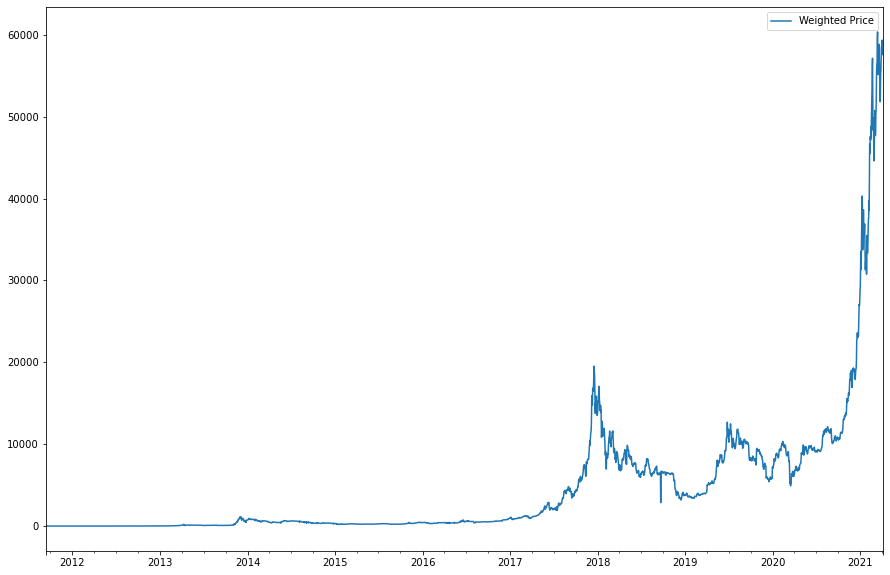

In [117]:
df_btc_data.groupby(df_btc_data.index).agg({'Weighted Price':'mean'}).plot(figsize=(15,10))